<a href="https://colab.research.google.com/github/frozin01/ML-Project/blob/main/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **TUGAS BESAR EL4125 PENGOLAHAN CITRA DIGITAL**
**Klasifikasi Penyakit pada Tanaman Tomat Dengan Pendekatan CNN dan Transfer Learning** (Kelompok C)
1. Rafif Rahman Darmawan / 13217015 
2. Fauzan Rozin / 13217040 
3. Cynthia Evani / 13217045


## **Import Library**

In [1]:
# import libraries
import os
import sys
import datetime
import glob as glob
import numpy as np
import cv2
import random

#import Keras model (VGG19)
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.models import Model
from keras.layers import Dense,GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator,array_to_img,img_to_array,load_img
from keras.optimizers import SGD

import tensorflow
import pandas as pd
import matplotlib.pyplot as plt

# import sklearn
from sklearn.metrics import confusion_matrix, classification_report

## **Preprocessing**

In [2]:
# upload dataset from local (disease.zip)
from google.colab import files
uploaded = files.upload()

Saving disease.zip to disease.zip


In [3]:
# extract uploaded zip file(s)
import zipfile
import io
data = zipfile.ZipFile(io.BytesIO(uploaded['disease.zip']), 'r')
data.extractall()

In [4]:
# check data directory
data.printdir()

Streaming output truncated to the last 5000 lines.
disease/train/Bacterial_Spot/12eda6e1-d42f-4e52-b04f-ff4f4d932783___GCREC_Bact.Sp 6275.JPG 2019-10-10 14:53:42        13742
disease/train/Bacterial_Spot/12f5fc61-6113-4baa-b1d4-c619bc895323___GCREC_Bact.Sp 3262.JPG 2019-10-10 14:53:42        12070
disease/train/Bacterial_Spot/132e8a85-470e-4a7d-8535-c97ffcff7b0b___GCREC_Bact.Sp 3239.JPG 2019-10-10 14:53:42        12666
disease/train/Bacterial_Spot/1347d766-5747-4d71-b05f-0211e79930b4___GCREC_Bact.Sp 6227.JPG 2019-10-10 14:53:42        14368
disease/train/Bacterial_Spot/1359bde0-60d2-497b-8a90-d59f9efb5fc1___GCREC_Bact.Sp 3278.JPG 2019-10-10 14:53:42        12216
disease/train/Bacterial_Spot/1371d8ed-b95f-4dd0-834c-9f3a944ca8dd___GCREC_Bact.Sp 3463.JPG 2019-10-10 14:53:42        12345
disease/train/Bacterial_Spot/137ffef0-7f3d-4610-82f5-f59f9826b926___UF.GRC_BS_Lab Leaf 9109.JPG 2019-10-10 14:53:42        10151
disease/train/Bacterial_Spot/13a0b443-c0b3-45fe-a22d-965a87a9b45e___GCREC_Ba

In [5]:
# image dimensions for VGG19 are 224, 224
img_width, img_height = 224, 224

# define train and valid directory
train_dir = 'disease/train'
valid_dir = 'disease/valid'

In [6]:
# define parameters
nb_epochs = 5
batch_size = 64
nb_classes = len(glob.glob(train_dir+'/*'))

# get number of images in training directory
nb_train_samples = 0
for r, dirs, files in os.walk(train_dir):
  for dr in dirs:
    nb_train_samples +=len(glob.glob(os.path.join(r, dr + "/*")))

# get number of images in validation directory
nb_validate_samples = 0
for r, dirs, files in os.walk(valid_dir):
  for dr in dirs:
    nb_validate_samples += len(glob.glob(os.path.join(r, dr + "/*")))

In [7]:
# data preprocessing for training
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

# data preprocessing for validation
valid_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

In [8]:
# generate and store training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical'
)

# generate and store validation data
valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 4500 images belonging to 3 classes.
Found 563 images belonging to 3 classes.


## **Pembuatan Model**

In [9]:
# set up transfer learning on VGG19
# remove fully connected layer and add classifier
base_model = VGG19(weights = 'imagenet', include_top = False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
predictions = Dense(nb_classes, activation = 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

80150528/80134624 [==============================] - 1s 0us/step


In [10]:
# freeze all layes of the pretrained model
for layer in base_model.layers:
  layer.trainable = False

In [11]:
# compile the new model
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [12]:
# get model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [13]:
# fit the model, log the training time
now = datetime.datetime.now
t = now()

transfer_learning_history = model.fit_generator(
    train_generator,
    epochs = nb_epochs,
    steps_per_epoch = len(train_generator),
    validation_data = valid_generator,
    validation_steps = len(valid_generator)
)
print('Training time: %s' % (now() - t))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
71/71 [==============================] - 3258s 46s/step - loss: 0.7550 - accuracy: 0.6883 - val_loss: 0.2621 - val_accuracy: 0.9183
Epoch 2/5
71/71 [==============================] - 3217s 45s/step - loss: 0.2304 - accuracy: 0.9358 - val_loss: 0.1542 - val_accuracy: 0.9574
Epoch 3/5
71/71 [==============================] - 3345s 47s/step - loss: 0.1356 - accuracy: 0.9618 - val_loss: 0.1214 - val_accuracy: 0.9574
Epoch 4/5
71/71 [==============================] - 3223s 45s/step - loss: 0.1278 - accuracy: 0.9581 - val_loss: 0.1075 - val_accuracy: 0.9591
Epoch 5/5
71/71 [==============================] - 3265s 46s/step - loss: 0.1052 - accuracy: 0.9639 - val_loss: 0.1068 - val_accuracy: 0.9574
Training time: 4:33:50.377464


In [14]:
# evaluate the performance of the new model
score = model.evaluate_generator(valid_generator, nb_validate_samples/batch_size)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

# save the transfer learning model
model.save('VGG19_modelv1.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test Score: 0.1145423874258995
Test Accuracy: 0.9555950164794922


## **Akurasi dan Loss**

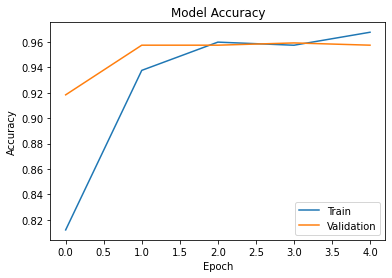

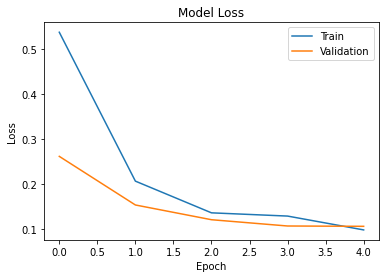

<Figure size 432x288 with 0 Axes>

In [17]:
# plot accuracy history
plt.plot(transfer_learning_history.history['accuracy'], label='Train')
plt.plot(transfer_learning_history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

# plot loss history
plt.plot(transfer_learning_history.history['loss'], label='Train')
plt.plot(transfer_learning_history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

## **Test Case**

In [ ]:
# upload the saved model from local (VGG19_modelv1.h5)
from google.colab import files
uploaded = files.upload()

In [18]:
# load model
import keras
import tensorflow as tf
         
model = tf.keras.models.load_model('VGG19_modelv1.h5')
         
print('Model loaded!')

Model loaded!


In [29]:
# this is a prediction of all Bacterial Spot test data
num_images = len(glob.glob("disease/test/Bacterial_Spot/*"))
predict_files = glob.glob("disease/test/Bacterial_Spot/*")

im = cv2.imread(predict_files[0])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (256, 256)).astype(np.float32)
im = np.expand_dims(im, axis = 0)/255

predictor, image_id = [], []
for i in predict_files:
  im = cv2.imread(i)
  im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256)).astype(np.float32)/255.0
  im = np.expand_dims(im, axis = 0)
  outcome = [np.argmax(model.predict(im))]
  predictor.extend(list(outcome))
  image_id.extend([i.rsplit("\\")[-1]])

final = pd.DataFrame()
final["id"] = image_id
final["disease"] = predictor

classes = train_generator.class_indices
classes = {value : key for key, value in classes.items()}

final["disease"] = final["disease"].apply(lambda x: classes[x])
final.head(num_images)

,id,disease
0,disease/test/Bacterial_Spot/2f946796-28fd-458c...,Bacterial_Spot
1,disease/test/Bacterial_Spot/3f34a2bd-b608-43dc...,Bacterial_Spot
2,disease/test/Bacterial_Spot/3f71f836-8ffa-4bf7...,Bacterial_Spot
3,disease/test/Bacterial_Spot/3a5a5fef-8a3a-4f70...,Bacterial_Spot
4,disease/test/Bacterial_Spot/3f34d522-9184-4f1e...,Bacterial_Spot
...,...,...
208,disease/test/Bacterial_Spot/0e16b13c-0308-4199...,Bacterial_Spot
209,disease/test/Bacterial_Spot/0c32d6d5-bf5b-4904...,Bacterial_Spot
210,disease/test/Bacterial_Spot/3fb6cd38-45c6-4ea1...,Bacterial_Spot
211,disease/test/Bacterial_Spot/3a8cc574-c2a6-4663...,Bacterial_Spot


In [30]:
# save predictions to csv file
final.to_csv("predictions_bacterial_spot.csv", index=False)

In [31]:
# this is a prediction of all Healthy test data
num_images = len(glob.glob("disease/test/Healthy/*"))
predict_files = glob.glob("disease/test/Healthy/*")

im = cv2.imread(predict_files[0])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (256, 256)).astype(np.float32)
im = np.expand_dims(im, axis = 0)/255

predictor, image_id = [], []
for i in predict_files:
  im = cv2.imread(i)
  im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256)).astype(np.float32)/255.0
  im = np.expand_dims(im, axis = 0)
  outcome = [np.argmax(model.predict(im))]
  predictor.extend(list(outcome))
  image_id.extend([i.rsplit("\\")[-1]])

final = pd.DataFrame()
final["id"] = image_id
final["disease"] = predictor

classes = train_generator.class_indices
classes = {value : key for key, value in classes.items()}

final["disease"] = final["disease"].apply(lambda x: classes[x])
final.head(num_images)

,id,disease
0,disease/test/Healthy/0fee8af3-ca03-418c-a71c-c...,Healthy
1,disease/test/Healthy/0d789240-9714-4378-8b63-4...,Healthy
2,disease/test/Healthy/1bfeed83-f119-46cd-b806-0...,Healthy
3,disease/test/Healthy/2b14b93f-0664-4b7f-93fa-b...,Healthy
4,disease/test/Healthy/1a02fa87-a194-482e-b4ac-8...,Healthy
...,...,...
154,disease/test/Healthy/0cb10f98-491d-4e1f-b8ea-4...,Healthy
155,disease/test/Healthy/1b966d62-d5c3-4a67-ba36-b...,Healthy
156,disease/test/Healthy/2b37cb9f-75c0-4e26-b82a-0...,Healthy
157,disease/test/Healthy/0a205a11-1e64-49f7-93c2-a...,Healthy


In [32]:
# save predictions to csv file
final.to_csv("predictions_healthy.csv", index=False)

In [33]:
# this is a prediction of all Late Blight test data
num_images = len(glob.glob("disease/test/Late_Blight/*"))
predict_files = glob.glob("disease/test/Late_Blight/*")

im = cv2.imread(predict_files[0])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (256, 256)).astype(np.float32)
im = np.expand_dims(im, axis = 0)/255

predictor, image_id = [], []
for i in predict_files:
  im = cv2.imread(i)
  im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256)).astype(np.float32)/255.0
  im = np.expand_dims(im, axis = 0)
  outcome = [np.argmax(model.predict(im))]
  predictor.extend(list(outcome))
  image_id.extend([i.rsplit("\\")[-1]])

final = pd.DataFrame()
final["id"] = image_id
final["disease"] = predictor

classes = train_generator.class_indices
classes = {value : key for key, value in classes.items()}

final["disease"] = final["disease"].apply(lambda x: classes[x])
final.head(num_images)

,id,disease
0,disease/test/Late_Blight/1a895389-ec7f-4622-af...,Late_Blight
1,disease/test/Late_Blight/3a0cd50f-708e-478a-92...,Late_Blight
2,disease/test/Late_Blight/0db85707-41f9-42df-ba...,Bacterial_Spot
3,disease/test/Late_Blight/1aa4ebf9-7329-4108-94...,Late_Blight
4,disease/test/Late_Blight/3d43c9c6-7b87-4c79-81...,Late_Blight
...,...,...
186,disease/test/Late_Blight/3f5d6de4-0966-4798-b1...,Late_Blight
187,disease/test/Late_Blight/2b3bc2ea-6604-4b73-9e...,Late_Blight
188,disease/test/Late_Blight/2edc83c5-b45e-4f4e-ba...,Bacterial_Spot
189,disease/test/Late_Blight/03e8a2f9-6a7e-43dd-8a...,Late_Blight


In [34]:
# save predictions to csv file
final.to_csv("predictions_late_blight.csv", index=False)

## **Evaluasi (Confusion Matrix & Classification Report)**

In [23]:
#define test data directory
test_dir = 'disease/test'

In [24]:
# data preprocessing for testing
test_datagen = ImageDataGenerator(
    rescale = 1./255
)
         
# generate and store testing data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

Found 563 images belonging to 3 classes.


In [26]:
# function to visualize confusion matrix better
def plot_cm(cm, classes, figname,
            normalize=False,
            title='Confusion Matrix',
            cmap=plt.cm.Blues):
         
         import numpy as np
         import matplotlib.pyplot as plt
         import itertools
         
         if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print('Normalized confusion matrix')
         else:
            print('Confusion matrix, without normalization')
         
         plt.figure(figsize=(8,8))
         plt.imshow(cm, interpolation='nearest', cmap=cmap)
         plt.title(title)
         #plt.colorbar()
         tick_marks = np.arange(len(classes))
         plt.xticks(tick_marks, classes, rotation=90)
         plt.yticks(tick_marks, classes)
         
         fmt ='.2f' if normalize else 'd'
         thresh = cm.max() / 2.
         for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
           plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="white" if cm[i, j] > thresh else "black")
         
         plt.ylabel('True label')
         plt.xlabel('Predicted label')
         plt.tight_layout()
         plt.savefig(figname)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


9/9 [==============================] - 355s 39s/step
Normalized confusion matrix


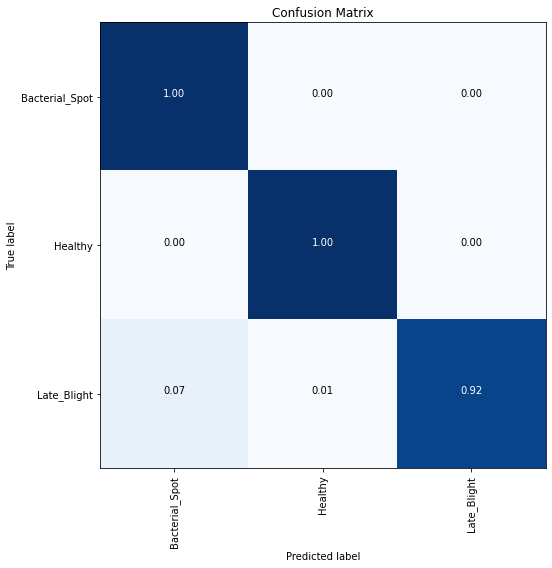

In [27]:
# confusion matrix
category_names = sorted(os.listdir(test_dir))

Y_pred = model.predict_generator(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size), verbose=1, workers=0)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(test_generator.classes,y_pred)
plot_cm(cm, category_names, 'Confusion Matrix', True, 'Confusion Matrix')

In [28]:
# classification report
report = classification_report(test_generator.classes,y_pred,target_names=category_names)
print(report)

                precision    recall  f1-score   support

Bacterial_Spot       0.94      1.00      0.97       213
       Healthy       0.99      1.00      1.00       159
   Late_Blight       0.99      0.92      0.96       191

      accuracy                           0.97       563
     macro avg       0.98      0.97      0.97       563
  weighted avg       0.97      0.97      0.97       563

